In [1]:
import pandas as pd
import random
import numpy as np
import sklearn as sk
from scipy import stats
import statistics
import cvxpy as cvx
import xgboost
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
xgboost.__version__
from scipy.linalg import svd
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import math
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor, wait
from deap import base, creator, tools, algorithms

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_name = "./german.data"

#read file
all_data = pd.read_csv(
  file_name,
  sep = ' ',
  header=None
)

all_data.columns = ['checking_acct', 'duration_month', 'credit_hist',
                    'purpose', 'credit_amount', 'savings', 'employ_years',
                    'install_as_percent_of_disp_income', 'married_and_sex',
                    'other_debtors', 'resident_since', 'property',
                    'age', 'other_installments', 'housing', 'existing_credits',
                    'job', 'num_liable', 'telephone', 'foreign', 'ground_truth']

# translate from codes to descriptive things
all_data.replace({"checking_acct": {'A11' : 1,
 'A12' : 2,
 'A13' : 3,
 'A14' : 0}}, inplace=True)

all_data.replace({"credit_hist": {'A30' : 0,
 'A31' : 1,
 'A32' : 2,
 'A33' : 3,
 'A34' : 4}}, inplace=True)

all_data.replace({"purpose": {
 'A40' : 0,
 'A41' : 1,
 'A42' : 2,
 'A43' : 3,
 'A44' : 4,
 'A45' : 5,
 'A46' : 6,
 'A47' : 7,
 'A48' : 8,
 'A49' : 9,
 'A410' : 10}}, inplace=True)

all_data.replace({"savings": {
 'A61' : 1,
 'A62' : 2,
 'A63' : 3,
 'A64' : 4,
 'A65' : 0}}, inplace=True)

all_data.replace({"employ_years": {
 'A71' : 0,
 'A72' : 1,
 'A73' : 2,
 'A74' : 3,
 'A75' : 4}}, inplace=True)

all_data.replace({"married_and_sex": {
 'A91' : 'male_div_sep',
 'A92' : 'female_div_sep_married',
 'A93' : 'male_single',
 'A94' : 'male_married_widowed',
 'A95' : 'female_single'}}, inplace=True)

all_data.replace({"other_debtors": {
 'A101' : 0,
 'A102' : 1,
 'A103' : 2}}, inplace=True)

all_data.replace({"property": {
 'A121' : 1,
 'A122' : 2,
 'A123' : 3,
 'A124' : 0}}, inplace=True)

all_data.replace({"other_installments": {
 'A141' : 1,
 'A142' : 2,
 'A143' : 0}}, inplace=True)

all_data.replace({"housing": {
 'A151' : 0,
 'A152' : 1,
 'A153' : 2}}, inplace=True)

all_data.replace({"job": {
 'A171' : 0,
 'A172' : 1,
 'A173' : 2,
 'A174' : 3}}, inplace=True)

all_data.replace({"telephone": {
 'A191' : 0,
 'A192' : 1}}, inplace=True)

all_data.replace({"foreign": {
 'A201' : 0,
 'A202' : 1}}, inplace=True)

all_data.replace({"ground_truth": {
 1 : 'accepted',
 2 : 'dennied'}}, inplace=True)


all_data.head()

,checking_acct,duration_month,credit_hist,purpose,credit_amount,savings,employ_years,install_as_percent_of_disp_income,married_and_sex,other_debtors,...,property,age,other_installments,housing,existing_credits,job,num_liable,telephone,foreign,ground_truth
0,1,6,4,3,1169,0,4,4,male_single,0,...,1,67,0,1,2,2,1,1,0,accepted
1,2,48,2,3,5951,1,2,2,female_div_sep_married,0,...,1,22,0,1,1,2,1,0,0,dennied
2,0,12,4,6,2096,1,3,2,male_single,0,...,1,49,0,1,1,1,2,0,0,accepted
3,1,42,2,2,7882,1,3,2,male_single,2,...,2,45,0,2,1,2,2,0,0,accepted
4,1,24,3,0,4870,1,2,3,male_single,0,...,0,53,0,2,2,2,2,0,0,dennied


In [3]:
learning_data = all_data.copy(deep=True)
features_to_transform = []

temp = pd.DataFrame()
temp['sex'] = learning_data['married_and_sex'].map(lambda x: x.split("_")[0])
dummies = pd.get_dummies(temp["sex"], prefix="sex")
learning_data = pd.concat([learning_data, dummies], axis=1)

for feature in features_to_transform:
    dummies = pd.get_dummies(learning_data[feature], prefix=feature)
    learning_data = pd.concat([learning_data, dummies], axis=1)
learning_data.head()

learning_data.columns = learning_data.columns.str.replace(' ', '_')
learning_data.columns = learning_data.columns.str.replace('-', '_')

learning_data['ground_truth_label'] = np.where(learning_data['ground_truth'] == 'accepted', 'accepted', 'dennied')
dummies = pd.get_dummies(learning_data['ground_truth_label'])
learning_data = pd.concat([learning_data, dummies] , axis = 1)
features_to_transform.append("ground_truth")
learning_data.drop(features_to_transform, axis=1, inplace=True)
learning_data.drop("married_and_sex", axis=1, inplace=True)
learning_data.head()
print(learning_data['num_liable'].max())

2


In [4]:
X_Labels = ['checking_acct', 'duration_month', 'credit_hist', 'purpose',
            'credit_amount', 'savings', 'employ_years',
            'install_as_percent_of_disp_income', 'other_debtors', 
            'resident_since', 'property', 'age', 'other_installments', 
            'housing', 'existing_credits','job', 'num_liable', 
            'telephone', 'foreign', 'sex_male']
Y_Labels = ['accepted']

X =  learning_data.loc[:, X_Labels]
Y =  learning_data.loc[:, Y_Labels]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =  0.2, random_state =  4)

# find and later remove linearly correlated pairs (not for xgboost but for LOCO later)
corr_thresh = .7
for column_a in X.columns:
    for column_b in X.columns:
        if column_a is not column_b:
            if X[column_a].corr(X[column_b]) > corr_thresh:
                print(str(column_a) + " " + str(column_b))
    

xgb_full = xgboost.DMatrix(X, label=Y)
xgb_train =  xgboost.DMatrix(X_train, label = Y_train)
xgb_test = xgboost.DMatrix(X_test, label = Y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.0002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    "tree_method": 'gpu_hist',
    "subsample": 0.35
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params, xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
learning_data['pred'] = model.predict(xgb_full)

[0]	test-auc:0.63685
[1000]	test-auc:0.77161
[2000]	test-auc:0.77581
[3000]	test-auc:0.77882
[4000]	test-auc:0.78243
[5000]	test-auc:0.78639
[6000]	test-auc:0.78820
[7000]	test-auc:0.79036
[8000]	test-auc:0.79445
[9000]	test-auc:0.79649
[9999]	test-auc:0.79829


In [5]:
plt.hist(learning_data['pred'], bins = 20)
plt.show() 

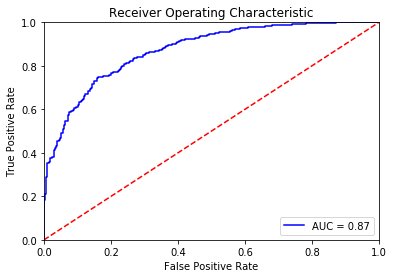

Optimal Threshold obtained using difference of TPR and FPR 0.65708095


In [6]:
%matplotlib inline
fpr, tpr , thresholds = roc_curve(learning_data['accepted'], learning_data['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
learning_data['y_pred'] = np.where(learning_data['pred'] > optimal_threshold, 1, 0)

## Find Burden

In [7]:
def d(indiv, other, cat, con, madArray, pred_func, columns=X_Labels):    
    dfm = pd.DataFrame([indiv, other], columns=columns)    
    preds = pred_func(xgboost.DMatrix(dfm))
    
    if preds.round().sum() != 1:
        return -1,
    
    ncat = len(cat)
    ncon = len(con)
            
    # MAD normalized L1 Norm
    normedl1norm = 0
    for index in con:
        mad = madArray[index]
        normedl1norm += abs(indiv[index] - other[index]) / mad

        
    # simpMat
    # both pos
    npindiv = np.array(indiv).astype(int)[cat]
    npother = np.array(other).astype(int)[cat]
        
    PosMat = npindiv & npother 
    NegMat = (1 - npindiv) & (1 - npother)
    total = npother.shape[0]
    dist = 1-((PosMat.sum() + NegMat.sum())/total)
        
    n = ncat + ncon
    return (1/(ncon*normedl1norm/n + ncat*dist/n),)

In [8]:
b = {
    'checking_acct':   ("catagorical", 4), 
    'duration_month':   ("continous", 80), 
    'credit_hist':   ("catagorical", 5), 
    'purpose':   ("catagorical", 11),
    'credit_amount':   ("continous", 50000), 
    'savings':   ("catagorical", 5), 
    'employ_years':   ("catagorical", 5),
    'install_as_percent_of_disp_income':   ("continous", 50), 
    'other_debtors':   ("catagorical", 3), 
    'resident_since':   ("continous", 6), 
    'property':   ("catagorical", 4), 
    'age':   ("continous", 100), 
    'other_installments':   ("catagorical", 3), 
    'housing':   ("catagorical", 3), 
    'existing_credits':   ("continous", 8),
    'job':   ("catagorical", 4), 
    'num_liable':   ("continous", 4), 
    'telephone':   ("catagorical", 2), 
    'foreign':   ("catagorical", 2), 
    'sex_male':   ("catagorical", 2)
}
ordered_cols = X_Labels

madArr = [0] * len(ordered_cols)
for feature in ordered_cols:
    bounds = b[feature]
    if bounds[0].startswith("cont"):
        madArr[ordered_cols.index(feature)] = learning_data.loc[:, feature].mad()


cat_list = []
con_list = []

for feature in ordered_cols:
    if b[feature][0].startswith('cata'):
        cat_list.append(ordered_cols.index(feature))
    else:
        con_list.append(ordered_cols.index(feature))

def create_bound_func_arr():
    ret = [0] * len(X_Labels)
    for i in cat_list:
        ret[i] = toolbox.cata_2_var
    for i in con_list:
        ret[i] = toolbox.con_var
    return ret

def create_indiv():
    ret = [0] * len(X_Labels)
    for i in cat_list:
        ret[i] = toolbox.cata_2_var()
    for i in con_list:
        ret[i] = toolbox.con_var()
    return creator.Individual(ret)

def mutate(indiv, func_arr, prob_mut):
    for i in range(len(indiv)):
        if(random.random() <= prob_mut):
            indiv[i] = func_arr[i]()
    return indiv,

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("cata_2_var", random.randint, 0, 1)
toolbox.register("con_var", random.uniform, 0, 100)

toolbox.register("individual", create_indiv)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate, func_arr=create_bound_func_arr(), prob_mut=.5)
toolbox.register("select", tools.selTournament, tournsize=3)

In [10]:
burden_data = learning_data.copy()
burden_data = burden_data.loc[:,X_Labels]

c_facts = []

pop_size = min(len(X_Labels)**2, 30000)
gens = 40

for i in range(burden_data.shape[0]):
    
    iper = burden_data.iloc[i].values.tolist()
    toolbox.register("evaluate", d, other=iper, cat=cat_list, con=con_list, madArray=madArr, pred_func=model.predict)

    
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)

    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=gens, halloffame=hof, verbose=False)

    print(str(i), ": Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
    
    cfact_final = list(hof[0])
    cfact_final.append(hof[0].fitness.values[0])
        
    c_facts.append(cfact_final)
        
    toolbox.unregister("evaluate")

c_facts_df = pd.DataFrame(c_facts, columns=X_Labels+['fitness'], 
                          index=burden_data.index)
print(c_facts_df.shape)
c_facts_df.head()

0 : Best individual is: [1, 7.659582720277392, 0, 1, 90.57097087810726, 1, 0, 3.285483780617804, 0, 4.018250913396015, 0, 66.12531369578475, 0, 1, 2.2458987337271252, 0, 1.8632100951328834, 1, 0, 0]
with fitness: (0.4975866030218931,)
1 : Best individual is: [0, 47.7190786159127, 0, 1, 89.15267277924619, 1, 0, 1.1160025390271389, 0, 2.1777236946553535, 1, 21.654421331217133, 0, 1, 1.5393454243913918, 0, 1.9178054957500024, 0, 0, 0]
with fitness: (0.334016664800214,)
2 : Best individual is: [1, 9.180774784254996, 0, 0, 99.94286605260761, 1, 1, 2.046529723299584, 0, 2.5315500589288886, 0, 48.33431141759049, 0, 1, 1.3407837527814492, 1, 2.495173067408296, 0, 0, 1]
with fitness: (0.6081670852292895,)
3 : Best individual is: [0, 42.66175335228702, 0, 0, 98.2845927292377, 1, 1, 1.167240198132713, 0, 3.2733814565622077, 0, 42.15220192825407, 0, 0, 0.38393831944342205, 0, 2.017104697946881, 0, 0, 1]
with fitness: (0.39907027393750927,)
4 : Best individual is: [0, 22.40731854146428, 1, 0, 93.22

35 : Best individual is: [0, 44.44258087194499, 0, 1, 94.84019699321338, 1, 1, 3.6939636223678463, 0, 1.8298065346708192, 0, 25.721698293308005, 0, 1, 1.9062510191962367, 1, 1.1566164662133893, 0, 0, 1]
with fitness: (0.7786319689839918,)
36 : Best individual is: [1, 48.2569781190794, 0, 0, 31.691027381023385, 1, 0, 0.34991495474732126, 0, 3.8039059483758186, 0, 29.324310801720088, 1, 0, 0.7273632106093886, 0, 1.0232758663917374, 1, 0, 1]
with fitness: (0.5287472287607434,)
37 : Best individual is: [1, 15.162237043915127, 0, 1, 48.71975229505613, 1, 0, 4.159581490896224, 1, 2.4740931991905413, 1, 41.98080297611057, 1, 0, 1.6272720194219215, 0, 1.25790709479644, 0, 0, 1]
with fitness: (0.5742478926112389,)
38 : Best individual is: [1, 8.625609010248459, 0, 0, 96.94284917718124, 1, 0, 2.5539936015692044, 0, 4.572430352433154, 1, 33.68020518239271, 0, 1, 1.4848233946495815, 1, 0.5400708291263601, 0, 0, 1]
with fitness: (0.39797291085406733,)
39 : Best individual is: [1, 9.913968414602891,

70 : Best individual is: [1, 34.43976687535296, 0, 1, 94.01567086310682, 1, 0, 0.28385508168712326, 0, 2.0225038018878205, 0, 29.937647416632586, 1, 1, 0.9677626265641281, 0, 0.7968381839096206, 0, 0, 0]
with fitness: (0.49048602233423455,)
71 : Best individual is: [1, 5.4014605321629166, 0, 0, 63.14221053332798, 1, 0, 4.46753945081968, 0, 2.0371221602508816, 1, 47.57271055731495, 1, 0, 1.0702963149099687, 1, 1.6115136800697982, 1, 0, 1]
with fitness: (0.47363390670192973,)
72 : Best individual is: [1, 9.79419429640458, 0, 0, 81.84745852207604, 1, 0, 3.909347430025034, 0, 3.2993892013529313, 0, 52.51385264927953, 1, 0, 2.364528235869512, 1, 2.0329971325838248, 1, 0, 1]
with fitness: (0.8552063901797998,)
73 : Best individual is: [1, 42.66417549841739, 0, 1, 88.16703135860664, 1, 1, 2.9005500790460825, 0, 0.795469467534482, 1, 42.18008687913025, 1, 1, 2.124800549173844, 1, 0.9995289323583512, 0, 0, 0]
with fitness: (0.6253846629042846,)
74 : Best individual is: [1, 36.45379312358939, 0,

105 : Best individual is: [0, 28.97512957775321, 0, 0, 91.33142342859651, 1, 0, 2.168555722127441, 1, 2.569356871155304, 1, 37.88875484148545, 0, 1, 2.6347471549500012, 1, 1.783395226070006, 1, 0, 1]
with fitness: (0.3143090980781946,)
106 : Best individual is: [1, 20.22719852157785, 1, 0, 78.34128195724486, 1, 0, 2.984660367015335, 0, 2.5574484076159476, 0, 43.69806239054497, 1, 1, 0.72769851385448, 1, 1.8846747337813108, 1, 0, 1]
with fitness: (0.3051750820436125,)
107 : Best individual is: [1, 11.29999032943786, 0, 0, 80.14038096405066, 1, 1, 2.566181951548041, 0, 1.831238178245631, 1, 33.60114761629017, 0, 1, 1.108065984558937, 0, 0.7995428782270442, 0, 0, 1]
with fitness: (0.5669330206046598,)
108 : Best individual is: [1, 20.244862025215383, 0, 0, 85.65254001090382, 0, 1, 1.062773931360672, 0, 2.1138755764666284, 0, 31.436559895349937, 0, 1, 0.5781502536786554, 0, 1.331232241869007, 1, 1, 0]
with fitness: (0.43670573728985657,)
109 : Best individual is: [1, 8.181678256104895, 0, 

140 : Best individual is: [1, 8.588482170113377, 0, 0, 97.24935074465387, 0, 1, 2.1397895597405348, 0, 0.6523937751418574, 1, 26.53693037502739, 0, 1, 1.0484727585213571, 0, 0.7664376987329691, 0, 1, 1]
with fitness: (0.9224732170582984,)
141 : Best individual is: [0, 32.900064393264806, 0, 1, 96.33112625316821, 1, 1, 4.414179889578429, 0, 1.9635136575901546, 0, 24.146052018443065, 0, 1, 1.2922518742517708, 1, 0.8667879340331641, 0, 0, 0]
with fitness: (0.48669290629677076,)
142 : Best individual is: [1, 26.53235813005076, 0, 1, 92.94794100817019, 1, 0, 2.7614438658922658, 0, 1.3361855421484048, 1, 26.691225728405655, 0, 0, 0.8038269110100416, 1, 1.1774956671946613, 0, 0, 1]
with fitness: (0.7494439020538007,)
143 : Best individual is: [1, 18.156833353153033, 0, 0, 45.77696874768945, 1, 0, 1.7072270437342163, 0, 0.9447735000612023, 0, 21.48094681929026, 0, 1, 0.9316247938028877, 0, 1.5425339321202713, 0, 0, 1]
with fitness: (0.5769596257416586,)
144 : Best individual is: [1, 22.4482770

175 : Best individual is: [1, 27.928887884275877, 1, 1, 79.99995436928424, 0, 0, 4.332695030273836, 0, 1.05605579851199, 1, 53.066601904283004, 1, 1, 1.5835484861157711, 0, 0.8601467996074641, 1, 0, 0]
with fitness: (0.4618894481349745,)
176 : Best individual is: [1, 10.416717865640468, 0, 0, 95.11423580628657, 1, 0, 1.8731016838368642, 0, 0.3670516414262859, 1, 41.889328666100454, 0, 1, 0.314873295572049, 1, 1.5746056729286306, 0, 0, 0]
with fitness: (0.47930934421959276,)
177 : Best individual is: [1, 6.94995155232061, 0, 1, 65.0217529371098, 1, 0, 4.583513277893814, 0, 3.653905360181897, 1, 47.58985506332499, 0, 1, 2.5768793196983886, 0, 1.5891424983755176, 0, 0, 1]
with fitness: (0.5682189628475559,)
178 : Best individual is: [1, 11.499011418926974, 0, 1, 51.685858523108266, 1, 1, 4.272362346226355, 0, 2.3735124942934616, 1, 26.37991356186291, 0, 0, 2.2747599505367755, 1, 2.9892166463545533, 1, 0, 1]
with fitness: (0.4329206454134709,)
179 : Best individual is: [1, 20.6565671424659

210 : Best individual is: [1, 7.9795238250498945, 0, 1, 81.56542316070676, 0, 0, 0.8864199942124285, 0, 2.5524955907772706, 1, 27.070369288236684, 0, 1, 0.6070891146686352, 0, 1.8392806075329449, 0, 0, 0]
with fitness: (0.4398798558366589,)
211 : Best individual is: [1, 36.59237758279331, 0, 1, 79.68617992134774, 0, 0, 1.9457015632477592, 0, 3.4038340715937476, 1, 45.24507580530085, 0, 1, 1.029346838585854, 0, 0.4485340061665455, 1, 0, 0]
with fitness: (0.5689601731122778,)
212 : Best individual is: [0, 28.140579451846293, 1, 1, 89.80497408333238, 1, 0, 2.0161187426837035, 0, 3.5585298830107193, 0, 46.00276638720313, 0, 1, 2.1116211698301024, 0, 2.082145685374359, 1, 0, 1]
with fitness: (0.3486835271860131,)
213 : Best individual is: [1, 32.488799839564344, 1, 1, 66.70461287664726, 1, 0, 4.977375858438393, 0, 3.6820602311000594, 1, 66.72410210849323, 0, 1, 1.0202416329502806, 1, 0.8853360546375977, 1, 0, 1]
with fitness: (0.943858852840017,)
214 : Best individual is: [1, 36.61516659490

245 : Best individual is: [1, 25.276758978847436, 0, 1, 82.0465051801505, 1, 1, 4.399495258955199, 0, 1.1034809613919117, 1, 24.153666720419885, 0, 1, 1.1237484805025955, 0, 1.3567690050176107, 1, 0, 1]
with fitness: (0.9349894423149198,)
246 : Best individual is: [1, 10.688987111379522, 0, 1, 92.0253610297218, 1, 0, 4.8559527864389, 0, 3.886804280630929, 1, 50.53786766374814, 0, 1, 2.219015456015283, 0, 1.222773781051667, 0, 0, 1]
with fitness: (0.6976731177733239,)
247 : Best individual is: [1, 9.858127481530687, 0, 0, 74.5293080460552, 0, 0, 4.346462205898227, 0, 1.274853866054615, 1, 40.05821875365836, 1, 0, 0.33513020251988435, 0, 1.1353107439679988, 0, 1, 1]
with fitness: (0.6743714605400322,)
248 : Best individual is: [1, 25.836084350874167, 0, 0, 72.68980170444094, 1, 0, 0.31674221945173775, 0, 2.047067257163393, 1, 26.087578074846675, 0, 1, 1.4676376934313229, 1, 0.9992663731157814, 0, 1, 1]
with fitness: (0.7042081095092416,)
249 : Best individual is: [1, 20.16377837998936, 0

280 : Best individual is: [1, 16.441977030150124, 0, 1, 83.12475634207381, 0, 0, 2.467155805551413, 0, 3.9626016879102277, 0, 29.668814683290666, 0, 0, 1.8860766478087543, 0, 0.9438033298973414, 1, 0, 1]
with fitness: (0.7826960696202927,)
281 : Best individual is: [1, 13.796901654875636, 0, 0, 97.80802990776529, 1, 0, 5.56869362635587, 0, 1.7440977754421882, 1, 55.68308541088939, 0, 1, 1.3786212952597965, 0, 0.857108042019461, 0, 0, 1]
with fitness: (0.5941075048797944,)
282 : Best individual is: [1, 16.94526851027971, 0, 1, 83.10796457656362, 0, 1, 4.5970525286565085, 0, 5.5576559755030726, 1, 49.344392658370765, 1, 1, 0.6096354629919865, 1, 1.4664830768052362, 1, 0, 1]
with fitness: (0.49253524102976304,)
283 : Best individual is: [1, 16.20832058692676, 0, 0, 92.69190260284232, 0, 0, 4.3458235733871975, 0, 2.031160149025246, 0, 60.453805675704565, 0, 1, 1.1084298352970867, 0, 0.9095450745251976, 0, 0, 1]
with fitness: (0.6928494095620273,)
284 : Best individual is: [1, 24.6927595993

315 : Best individual is: [0, 38.474224136217295, 1, 0, 78.1431113964495, 1, 0, 4.237848631440134, 0, 4.233474739483423, 1, 28.971237790364235, 1, 1, 1.165941752601507, 0, 0.9877971260254137, 0, 0, 1]
with fitness: (1.0300738911053013,)
316 : Best individual is: [1, 13.796290614041629, 0, 0, 29.835256061784232, 1, 0, 2.5776946786851385, 0, 2.5542890173386956, 1, 35.73754952679917, 0, 1, 0.7086720719360451, 1, 2.368606289684072, 0, 0, 1]
with fitness: (0.7292952935316909,)
317 : Best individual is: [1, 23.006203245261958, 0, 0, 99.25635394310268, 0, 0, 0.9756445467714481, 0, 2.78163837231713, 0, 48.7838014539967, 0, 1, 1.1081521578132025, 1, 1.0615930100868587, 1, 0, 0]
with fitness: (0.6972618490148195,)
318 : Best individual is: [1, 11.238132274135237, 0, 0, 98.18206359854244, 1, 0, 3.8286584652587274, 0, 1.8210217856175492, 0, 32.55617164376806, 0, 1, 1.4104409044163768, 0, 1.0955550996232577, 0, 0, 1]
with fitness: (1.1059266891619786,)
319 : Best individual is: [1, 15.1469264282382

350 : Best individual is: [1, 7.426756126570455, 0, 0, 77.91054758319903, 1, 1, 0.37928654747696466, 1, 2.8611781836970107, 0, 22.650409912167056, 0, 0, 0.6235330730726352, 0, 0.5789850271660235, 1, 0, 0]
with fitness: (0.5386628207205363,)
351 : Best individual is: [1, 5.231424198800861, 0, 0, 99.95700605459561, 1, 0, 1.3372062642784677, 0, 2.434107329559698, 1, 28.175462294887954, 0, 1, 1.0276243721739187, 0, 1.5437952760063212, 0, 1, 0]
with fitness: (0.7222495039904262,)
352 : Best individual is: [1, 16.468931032564093, 0, 1, 90.37565900489216, 0, 0, 2.429966731370836, 0, 4.208275873030365, 0, 36.86689936816471, 0, 1, 1.0090132769611904, 1, 0.6005397559078585, 1, 0, 1]
with fitness: (0.6887326937773215,)
353 : Best individual is: [0, 6.102377625403466, 0, 1, 43.22664638916145, 1, 0, 3.9161652916504197, 0, 2.1864039600601903, 0, 29.603629959427955, 0, 0, 1.4361944011321626, 1, 1.0820465854128214, 1, 0, 1]
with fitness: (0.4953298168213268,)
354 : Best individual is: [1, 9.9705924761

385 : Best individual is: [1, 17.589975370884225, 0, 1, 27.619001223823336, 1, 0, 2.4407749491771824, 0, 1.0697527259185824, 1, 22.987242764586103, 0, 1, 1.7424426798300807, 0, 0.6909556594348554, 0, 0, 0]
with fitness: (0.7754791971561902,)
386 : Best individual is: [1, 18.907833901213856, 0, 1, 93.76253938466539, 0, 1, 4.0657841488410895, 0, 2.4838172392114277, 0, 21.224268177333762, 0, 0, 0.29623182706852713, 0, 0.9964853087747971, 1, 0, 0]
with fitness: (1.00613337991993,)
387 : Best individual is: [1, 17.441491270020226, 0, 0, 51.8094877720675, 1, 0, 3.7720496476290943, 0, 3.404470181678565, 0, 38.420358730306894, 0, 1, 1.7362998430844767, 1, 1.343996474648379, 1, 0, 1]
with fitness: (0.43273280199075126,)
388 : Best individual is: [1, 14.800532428926772, 0, 1, 95.6010481519923, 1, 0, 2.0687305083334717, 0, 4.032530771571907, 1, 29.816021623783172, 1, 1, 0.4092845486855068, 0, 1.4485901149969505, 0, 0, 1]
with fitness: (0.6313040744243427,)
389 : Best individual is: [1, 10.3735098

420 : Best individual is: [1, 16.605925553521306, 0, 0, 50.16854546998006, 0, 1, 2.5806063074356844, 0, 2.6097520244834804, 1, 18.948422410618605, 0, 0, 0.711034555346135, 0, 0.6109776081365093, 0, 0, 0]
with fitness: (0.5732573855732379,)
421 : Best individual is: [1, 8.393947492243415, 0, 1, 87.44152302994188, 0, 0, 4.245179250839149, 0, 1.738262936211088, 1, 31.668500563936597, 0, 1, 0.4683453905674151, 0, 1.0260560586740186, 0, 0, 1]
with fitness: (0.8667729201460395,)
422 : Best individual is: [1, 16.656730957179143, 0, 0, 98.83338917409934, 1, 0, 2.110077821843137, 0, 3.162553610345098, 0, 49.61121459752137, 0, 1, 1.9033217738331665, 0, 2.000300701283242, 0, 0, 0]
with fitness: (1.2023682377335803,)
423 : Best individual is: [1, 22.246190206632654, 1, 0, 82.59195194209025, 0, 1, 2.8534973665075403, 0, 3.6916769754215872, 1, 29.7028691120532, 0, 1, 1.8207361986381176, 1, 1.0258014617022915, 0, 0, 1]
with fitness: (0.7544623722444443,)
424 : Best individual is: [1, 13.3634691151286

455 : Best individual is: [1, 25.317230677797976, 0, 1, 84.58709488392029, 1, 1, 4.613835280223489, 0, 2.1778109564791315, 0, 32.87945543468095, 0, 1, 1.04093047936209, 1, 1.3155952377196245, 1, 0, 0]
with fitness: (0.5644237833488015,)
456 : Best individual is: [1, 9.093553086953342, 0, 0, 92.93277231993345, 1, 0, 1.7040780729738247, 0, 1.3968641965043105, 1, 37.60966327908509, 0, 0, 1.286480400154577, 1, 2.214291908413435, 0, 0, 1]
with fitness: (0.5205482534901642,)
457 : Best individual is: [1, 11.156111942201896, 0, 1, 88.4669280664942, 1, 0, 4.064489149011397, 0, 3.873700175970418, 0, 35.38363255263256, 0, 0, 0.9851252586386972, 0, 0.7864453809069638, 1, 0, 1]
with fitness: (0.7536929990800769,)
458 : Best individual is: [1, 7.291138286847931, 0, 0, 90.03110122032032, 1, 1, 4.709462077109327, 0, 2.808033788533393, 1, 26.71103489021409, 0, 1, 1.0040169473670035, 0, 1.2901123495123623, 0, 0, 0]
with fitness: (0.7263049738263064,)
459 : Best individual is: [1, 17.303417610417426, 0,

490 : Best individual is: [1, 12.266342657401664, 0, 1, 99.49802552550203, 1, 0, 2.1191126829101847, 0, 3.0729054167940584, 0, 26.03130544552259, 0, 1, 1.436670976940213, 0, 1.0841794232773205, 0, 0, 1]
with fitness: (0.7768234166865331,)
491 : Best individual is: [0, 25.259601090507246, 0, 1, 89.90878469622326, 1, 0, 2.1946572827951094, 0, 4.213975818293381, 0, 38.236459517231715, 0, 0, 2.5362776632235073, 1, 1.3134821849476563, 1, 0, 0]
with fitness: (0.39324171685375814,)
492 : Best individual is: [1, 5.0611996378714945, 1, 1, 79.0939509924813, 0, 0, 1.5482158938523338, 0, 0.8074740683807868, 0, 28.45812053336042, 0, 1, 2.050909785700128, 0, 1.1499617619265767, 0, 0, 0]
with fitness: (1.128851334667476,)
493 : Best individual is: [1, 5.092926244054253, 0, 1, 65.5215511638852, 0, 0, 4.8858851551417555, 0, 5.177266045305339, 0, 34.582523840499356, 0, 1, 2.3688867563456895, 0, 1.3549618587377354, 0, 0, 1]
with fitness: (0.4169969545144941,)
494 : Best individual is: [1, 11.208948972986

525 : Best individual is: [1, 26.33610069013079, 0, 1, 93.71508174773302, 1, 1, 2.457543032913112, 0, 4.186918307949106, 0, 29.558152251805613, 0, 1, 2.1931352390467507, 0, 0.746019636882933, 0, 0, 1]
with fitness: (0.3963878495082297,)
526 : Best individual is: [1, 13.470408261279987, 0, 0, 98.7757685620061, 0, 0, 6.030684122822083, 0, 3.6464441774401113, 1, 28.784438397098633, 0, 1, 1.7714736945494192, 0, 0.7196945243554631, 0, 0, 0]
with fitness: (0.4380927466097835,)
527 : Best individual is: [1, 15.504376397770125, 0, 1, 96.02022170702908, 1, 1, 2.9532683596680043, 0, 2.2734009289876345, 1, 45.92158435250475, 0, 1, 2.5785544401666805, 1, 2.1603843582441606, 0, 0, 1]
with fitness: (0.44293823135253385,)
528 : Best individual is: [0, 33.81158422111509, 0, 1, 96.1818801172451, 1, 0, 3.2504748506553605, 0, 5.227983726241847, 1, 29.76289370093873, 0, 0, 0.8454443141600043, 0, 0.9130178495360353, 0, 0, 1]
with fitness: (0.6791583786052064,)
529 : Best individual is: [1, 9.68670613413107

560 : Best individual is: [1, 22.04429381848775, 0, 1, 96.5904417103958, 0, 0, 4.569618733727799, 0, 4.59142726385533, 0, 47.87267525767515, 1, 0, 1.010437268885822, 0, 1.524357822201261, 1, 0, 1]
with fitness: (0.6033461068393583,)
561 : Best individual is: [0, 28.83308834632824, 1, 1, 36.700329790850475, 1, 1, 3.8726284760086993, 1, 4.802954475523091, 1, 29.659337105517082, 1, 0, 0.9880375353588211, 0, 0.9460086969795833, 0, 0, 1]
with fitness: (0.8251599203112899,)
562 : Best individual is: [1, 6.617293914937128, 1, 0, 95.4233014687168, 1, 1, 0.9835388717395865, 0, 0.3666221772937295, 1, 27.951801296975688, 1, 1, 1.8609644736175102, 0, 0.0005613519433844694, 0, 0, 0]
with fitness: (0.3614842841681919,)
563 : Best individual is: [0, 34.41103343843485, 0, 0, 90.04098090322505, 0, 0, 1.7769826077914108, 0, 4.866111397525175, 0, 35.434803954007066, 0, 0, 1.1249318970569022, 1, 0.7344795190099673, 1, 0, 1]
with fitness: (0.30404086640352357,)
564 : Best individual is: [1, 22.896515928234

595 : Best individual is: [0, 9.234932910980941, 1, 0, 0.9660446797685962, 0, 0, 0.8118470581397141, 0, 0.8603488258886571, 0, 33.25808592251776, 1, 1, 1.7137569294314092, 1, 1.5973340707358896, 0, 0, 0]
with fitness: (0.5477948967713427,)
596 : Best individual is: [0, 25.197719733167744, 0, 0, 93.78989783425433, 0, 1, 3.718259502152965, 0, 3.767871825914648, 1, 22.90212671418882, 0, 0, 3.131770029302128, 0, 1.4857863703658047, 0, 0, 0]
with fitness: (0.505727388174055,)
597 : Best individual is: [1, 24.1931215145216, 0, 1, 99.28899292820651, 1, 0, 0.02172862780781548, 0, 2.5900223587434934, 1, 37.311492508382024, 0, 0, 3.849926548647964, 1, 1.0618425873133663, 1, 0, 1]
with fitness: (0.4226310878382842,)
598 : Best individual is: [1, 18.08383037940253, 0, 0, 83.00333414055629, 1, 1, 1.1616240402161582, 0, 1.9141281630722151, 0, 28.024263183004916, 1, 1, 3.3955828579715464, 0, 0.8719688468899589, 0, 0, 1]
with fitness: (0.4819172951265969,)
599 : Best individual is: [1, 23.250620489194

630 : Best individual is: [1, 23.70631518507875, 0, 1, 33.866715808339755, 1, 0, 1.30863731104095, 0, 3.5709274916496003, 1, 34.512027624274154, 0, 1, 0.24390807958799554, 0, 0.774519258914963, 0, 0, 0]
with fitness: (0.4777274934566135,)
631 : Best individual is: [0, 17.522999372203095, 1, 0, 30.886718175003214, 1, 0, 4.592756061316505, 0, 2.1761140324840555, 1, 46.49724138880285, 1, 1, 0.2872363181615656, 0, 1.2441320579179238, 0, 0, 1]
with fitness: (0.5768710768247263,)
632 : Best individual is: [1, 16.015012727934753, 0, 1, 92.79242068023149, 0, 1, 3.1721979424293223, 0, 0.8422240800711189, 0, 20.866754121191853, 0, 1, 0.7504290003306213, 0, 1.1654716561722789, 0, 0, 1]
with fitness: (0.8767286259751749,)
633 : Best individual is: [1, 11.666276016834242, 0, 1, 58.833495697505626, 1, 1, 2.446340757553356, 1, 0.18402598928670688, 1, 17.965860364724673, 0, 0, 1.3288575946284298, 0, 1.252603164867383, 0, 0, 0]
with fitness: (0.4642827469398809,)
634 : Best individual is: [0, 21.761137

665 : Best individual is: [1, 27.70533318489453, 0, 0, 79.6828841816066, 1, 0, 3.261077443237448, 1, 1.5730602741968802, 0, 23.52063123191335, 1, 1, 0.8660453036350213, 1, 0.5198842459507969, 1, 0, 1]
with fitness: (0.31152344356919964,)
666 : Best individual is: [1, 27.509824151753083, 1, 0, 73.9462960319341, 0, 0, 3.901070548248309, 0, 2.8335943872980662, 1, 35.582219587895366, 0, 1, 0.3148661432241129, 0, 2.0874977205919576, 1, 0, 1]
with fitness: (0.5893099535220726,)
667 : Best individual is: [1, 47.747288487901464, 1, 1, 97.35505902869015, 1, 0, 1.7991624913907267, 0, 0.7852902840217335, 1, 23.906973049101854, 0, 1, 2.924791658805592, 0, 1.0289270396070083, 0, 0, 0]
with fitness: (0.4025634622516503,)
668 : Best individual is: [1, 13.65758851655846, 1, 0, 59.373835354058926, 0, 0, 2.4772492079387143, 1, 4.2437765901839235, 0, 43.96695449482646, 1, 1, 1.8448887987532414, 0, 1.2065554448051352, 1, 0, 0]
with fitness: (0.5500364552221167,)
669 : Best individual is: [1, 28.8129365480

700 : Best individual is: [1, 13.103943750020752, 0, 0, 99.4854005924399, 1, 0, 3.7475350442262467, 0, 3.3181823621165174, 1, 28.495128889727805, 0, 0, 0.41132373204948447, 1, 1.1116285715944807, 0, 0, 0]
with fitness: (0.8603354158908567,)
701 : Best individual is: [0, 50.11135383430385, 0, 1, 88.13972660580733, 1, 0, 4.152980089122682, 0, 2.921911882005146, 0, 48.74923409923441, 0, 0, 1.736708285840849, 0, 1.7979237333595632, 1, 0, 1]
with fitness: (0.3358463458501555,)
702 : Best individual is: [1, 23.91419053709104, 0, 1, 80.43629698828076, 0, 0, 3.957499623696803, 0, 2.020481600714341, 0, 46.82247980332546, 0, 0, 0.6311539882989159, 0, 0.7874201505918887, 1, 0, 0]
with fitness: (1.2683943438192982,)
703 : Best individual is: [1, 26.76223021110178, 0, 1, 55.32295847650413, 0, 0, 3.6065824143863057, 0, 1.820616721294288, 0, 44.59200499644549, 0, 1, 2.178931674167095, 0, 1.3910555263083269, 0, 0, 0]
with fitness: (0.5976397069147499,)
704 : Best individual is: [1, 27.64063773938503, 

735 : Best individual is: [0, 35.24937990037829, 1, 0, 93.24436964444895, 0, 1, 3.657740618205352, 0, 2.3813966921804597, 0, 29.19136527272518, 1, 1, 0.8705749391442974, 0, 1.840411185983848, 0, 0, 0]
with fitness: (0.4388721786603339,)
736 : Best individual is: [0, 23.497458788495827, 0, 1, 96.8492696656738, 1, 0, 1.1985627755374595, 0, 5.283111099048165, 1, 25.36004354880953, 0, 0, 1.122913340621845, 1, 0.5924418163186007, 1, 0, 0]
with fitness: (0.26466648009663646,)
737 : Best individual is: [1, 19.43071899869754, 0, 0, 97.20383118689986, 0, 0, 2.5975297492928706, 0, 3.873530802257763, 1, 34.11999066901077, 0, 1, 0.7524658813387375, 1, 1.9917416375693886, 1, 0, 1]
with fitness: (0.843987310464502,)
738 : Best individual is: [1, 7.583319451765568, 0, 0, 91.44395798837687, 1, 1, 1.1184748322968785, 0, 3.733207569403052, 0, 48.13079435722373, 0, 1, 2.6862004111601, 1, 2.1464325043689447, 1, 0, 1]
with fitness: (0.4292490243071218,)
739 : Best individual is: [0, 30.496998225414284, 0, 

770 : Best individual is: [1, 21.640722347642527, 0, 0, 5.847519563682857, 0, 0, 2.0864902150660614, 0, 4.165407414414169, 1, 23.90636393112239, 0, 0, 0.9401122275873641, 0, 0.7869090719743066, 0, 0, 0]
with fitness: (0.8996448280433741,)
771 : Best individual is: [0, 35.42183969309105, 0, 0, 99.78265096301153, 1, 0, 3.037368954644737, 0, 2.2123011927665304, 0, 26.1730505198133, 0, 1, 1.881886096355223, 1, 1.3992545173399429, 0, 0, 0]
with fitness: (0.44864820853163595,)
772 : Best individual is: [1, 19.927597986103052, 0, 1, 90.92936666616939, 1, 0, 0.2997498702135615, 0, 4.852414128964178, 1, 33.50349282114683, 0, 1, 1.6049807354916679, 1, 1.0927821638100799, 1, 0, 1]
with fitness: (0.5518606375257424,)
773 : Best individual is: [1, 23.432619575998437, 0, 1, 97.59366250277289, 0, 0, 3.555249511895653, 0, 4.013183723526814, 0, 53.792516262991796, 1, 1, 1.508179736131865, 0, 1.0611730481451143, 0, 0, 1]
with fitness: (0.924367890047608,)
774 : Best individual is: [1, 9.293686632865183,

805 : Best individual is: [0, 37.38229984972493, 0, 1, 88.96013392940195, 1, 1, 1.869740631162009, 0, 0.6770001498641376, 1, 24.796472214257157, 0, 1, 0.49306045783589214, 0, 1.0597760130766964, 1, 0, 1]
with fitness: (0.42843405595093353,)
806 : Best individual is: [1, 4.788840148584416, 0, 1, 38.12509276338911, 1, 1, 3.038343768425078, 0, 2.7488800275382697, 1, 26.867759163964667, 1, 1, 1.2843683803652972, 1, 1.3474892297449026, 1, 1, 1]
with fitness: (0.9246324244742864,)
807 : Best individual is: [1, 9.923461602111871, 0, 1, 70.4931922306553, 0, 0, 4.61950111150764, 0, 4.106221810288924, 1, 64.6984779047606, 0, 1, 4.468509193133752, 0, 0.9959177160013821, 0, 0, 1]
with fitness: (1.1549966940600855,)
808 : Best individual is: [0, 44.05343114379566, 1, 1, 83.15990442032445, 1, 0, 1.5876797552938249, 0, 3.4757419147366964, 0, 53.509014171723045, 1, 0, 0.60919342720408, 1, 1.003194318890932, 1, 0, 1]
with fitness: (0.37036846070680435,)
809 : Best individual is: [0, 14.887321256583498,

840 : Best individual is: [0, 37.73089736737995, 0, 0, 92.84698400271704, 1, 1, 4.57764844147327, 0, 3.8233056236936402, 0, 26.262137414941733, 0, 1, 0.7447956759764951, 0, 0.9470575532373515, 0, 0, 1]
with fitness: (0.45954618515499357,)
841 : Best individual is: [1, 26.00553434884868, 1, 1, 76.13342537738617, 1, 0, 3.377211230480892, 0, 1.0457559981265074, 1, 29.70857733503147, 1, 1, 2.0936198093718605, 0, 0.8847141332200215, 1, 0, 1]
with fitness: (0.6118054986869728,)
842 : Best individual is: [1, 19.05678851664986, 0, 1, 89.10881043690799, 1, 1, 3.8722075961271196, 0, 4.061496895395567, 1, 23.11377988109511, 0, 1, 2.9952716685753833, 0, 0.8379008621072215, 0, 0, 0]
with fitness: (0.4880707039744977,)
843 : Best individual is: [1, 25.872982215610584, 1, 1, 98.85986681348872, 1, 1, 3.926436467395622, 0, 4.31055160485958, 1, 44.924003514692465, 1, 1, 0.9536207816942199, 0, 0.4078026615891517, 1, 0, 1]
with fitness: (0.6566574501683463,)
844 : Best individual is: [1, 18.64721373037056

875 : Best individual is: [1, 11.34295076069234, 0, 0, 39.56055681268346, 0, 1, 3.2037143076201535, 0, 4.163905690130276, 1, 41.751681017131546, 0, 1, 1.8122097162275752, 0, 1.038270077830994, 1, 1, 0]
with fitness: (0.9820043063471607,)
876 : Best individual is: [0, 20.114091240682043, 1, 1, 73.57350226677329, 1, 1, 1.874883951397932, 1, 4.203198193405255, 0, 35.371108405882545, 1, 0, 0.9807619966376135, 1, 0.7546397339106781, 1, 0, 1]
with fitness: (0.7797265248168493,)
877 : Best individual is: [1, 35.944636220585494, 0, 1, 87.13262365822006, 1, 0, 4.380092709686345, 0, 3.183672298235607, 1, 21.9633062938573, 0, 1, 1.2658887107174666, 0, 0.7109772847976314, 0, 0, 1]
with fitness: (0.4996689246363628,)
878 : Best individual is: [1, 10.014424271743295, 0, 0, 95.80245066915381, 1, 1, 3.304838498609719, 0, 2.538474249838363, 0, 27.470194394971593, 0, 0, 1.5474465521509106, 1, 2.806332715060955, 1, 0, 1]
with fitness: (0.2972492410809625,)
879 : Best individual is: [1, 28.798567916126938

910 : Best individual is: [1, 36.565914590681224, 1, 0, 78.4437112380422, 1, 0, 3.4202635219392485, 0, 4.03999361694658, 1, 31.98386400412163, 0, 1, 1.4959801635266778, 0, 0.967744608736798, 0, 0, 0]
with fitness: (0.6444044814458257,)
911 : Best individual is: [1, 23.122551058997097, 0, 0, 92.13292042120239, 1, 1, 2.1938767017647964, 0, 3.989376376058096, 1, 26.56964335975519, 1, 1, 0.6000184752556592, 1, 0.7927764772899359, 0, 0, 0]
with fitness: (0.6419634609191913,)
912 : Best individual is: [1, 30.652084851639717, 0, 1, 76.57447052126942, 0, 0, 2.1875627279255183, 0, 3.1742061437387337, 1, 23.540323970913548, 1, 1, 0.6282355511099458, 0, 1.0169037539761394, 0, 0, 0]
with fitness: (0.7638154165925498,)
913 : Best individual is: [1, 14.923474179439678, 0, 1, 88.23275123595454, 1, 0, 1.5924128723023734, 0, 2.420786795530727, 1, 29.43371299344485, 0, 1, 0.4753517603797719, 0, 0.7710976964597438, 1, 0, 1]
with fitness: (0.5985151587294785,)
914 : Best individual is: [0, 24.867287696072

945 : Best individual is: [0, 48.13805996768351, 0, 0, 92.19579428174738, 1, 1, 0.07800461428345562, 0, 1.0443210837260075, 1, 30.04364891215413, 0, 1, 2.619465488737749, 0, 1.2349841076981671, 0, 0, 0]
with fitness: (0.4005605938995817,)
946 : Best individual is: [0, 21.66372122752701, 1, 0, 53.74405197230102, 1, 1, 4.606592936538911, 0, 3.854194594802185, 0, 33.42412097620747, 0, 0, 1.9286085572562617, 0, 2.621226314761882, 1, 0, 1]
with fitness: (0.39077740664433896,)
947 : Best individual is: [1, 10.458899617443452, 0, 0, 78.74716100900204, 0, 0, 4.023528418555166, 0, 4.411306100698031, 0, 39.126859151038886, 0, 1, 0.3905588661510362, 1, 1.3233701968318967, 1, 0, 1]
with fitness: (0.6158306406626624,)
948 : Best individual is: [1, 17.52679871984273, 0, 0, 75.57689598376845, 1, 1, 4.905506048683039, 1, 0.6142689281258829, 0, 43.10433062432032, 0, 1, 0.541089926603433, 1, 2.164390327745902, 0, 0, 1]
with fitness: (0.7644064845954759,)
949 : Best individual is: [1, 23.88900538829458, 

980 : Best individual is: [1, 33.18530349622553, 0, 0, 35.59831872074418, 1, 1, 2.843398112051998, 0, 2.2672206368860137, 0, 50.46380617143475, 0, 0, 1.0493773390444439, 0, 0.9450484278080484, 0, 0, 1]
with fitness: (0.4544120571803698,)
981 : Best individual is: [0, 51.06113880308325, 0, 1, 18.323627397143472, 1, 0, 3.1493519999967745, 0, 2.327357852366685, 1, 34.572707027420904, 1, 0, 0.36535480250032837, 1, 0.8914764495329353, 1, 0, 1]
with fitness: (0.5740735278479309,)
982 : Best individual is: [1, 22.445307206324717, 0, 0, 83.9908507129378, 0, 0, 2.039434196664325, 1, 0.9983665108038053, 1, 25.503582776226587, 1, 1, 3.857452592350752, 0, 1.7685366245061007, 1, 1, 0]
with fitness: (0.24257522689686437,)
983 : Best individual is: [0, 32.89524167194776, 0, 1, 40.807145216334526, 1, 0, 1.3636708096452788, 0, 2.508796833108329, 0, 26.72199646073463, 0, 0, 0.7591690818610997, 0, 2.121268370225704, 0, 0, 1]
with fitness: (0.42178109991212526,)
984 : Best individual is: [1, 23.5124224472

,checking_acct,duration_month,credit_hist,purpose,credit_amount,savings,employ_years,install_as_percent_of_disp_income,other_debtors,resident_since,...,age,other_installments,housing,existing_credits,job,num_liable,telephone,foreign,sex_male,fitness
0,1,7.659583,0,1,90.570971,1,0,3.285484,0,4.018251,...,66.125314,0,1,2.245899,0,1.863210,1,0,0,0.497587
1,0,47.719079,0,1,89.152673,1,0,1.116003,0,2.177724,...,21.654421,0,1,1.539345,0,1.917805,0,0,0,0.334017
2,1,9.180775,0,0,99.942866,1,1,2.046530,0,2.531550,...,48.334311,0,1,1.340784,1,2.495173,0,0,1,0.608167
3,0,42.661753,0,0,98.284593,1,1,1.167240,0,3.273381,...,42.152202,0,0,0.383938,0,2.017105,0,0,1,0.399070
4,0,22.407319,1,0,93.229054,1,0,3.110447,0,3.902831,...,52.875218,0,0,1.400503,0,2.331482,0,0,1,0.539669


In [11]:
burden_data['fitness'] = c_facts_df.fitness
burden_data['dist'] = 1/c_facts_df.fitness

burden_data.head()

,checking_acct,duration_month,credit_hist,purpose,credit_amount,savings,employ_years,install_as_percent_of_disp_income,other_debtors,resident_since,...,other_installments,housing,existing_credits,job,num_liable,telephone,foreign,sex_male,fitness,dist
0,1,6,4,3,1169,0,4,4,0,4,...,0,1,2,2,1,1,0,1,0.497587,2.009700
1,2,48,2,3,5951,1,2,2,0,2,...,0,1,1,2,1,0,0,0,0.334017,2.993863
2,0,12,4,6,2096,1,3,2,0,3,...,0,1,1,1,2,0,0,1,0.608167,1.644285
3,1,42,2,2,7882,1,3,2,2,4,...,0,2,1,2,2,0,0,1,0.399070,2.505824
4,1,24,3,0,4870,1,2,3,0,4,...,0,2,2,2,2,0,0,1,0.539669,1.852987


In [12]:
print(burden_data.groupby('sex_male', as_index=False)[['fitness','dist']].mean())


   sex_male   fitness      dist
0         0  0.678729  1.717652
1         1  0.623366  1.842840


In [13]:
from datetime import datetime

c_facts_df['id'] = c_facts_df.index
c_facts_df.to_csv("./germanCred_cfact_" + datetime.now().strftime("%m_%d_%Y_%H_%M") +".csv")

In [17]:

class Model:
    
    def __init__(self, datadf, cfdf):
        self.pred = datadf['pred'].copy()
        self.label = datadf['accepted'].copy()
        self.datadf = datadf.copy()
        self.cfdf = cfdf.copy()
        self.datadf['cfact_dist'] = 1/cfdf['fitness']
        self.datadf = self.datadf.query("cfact_dist == cfact_dist")
                    
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label
    
    def get_burden(self):
        return self.datadf['cfact_dist'].mean()

    def burden_eq_opp(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
                   
        print(1-sp2p, sn2p, 1-op2p, on2p, "pburden")
        # find indices close to the border and flip them
        if self.get_burden() > othr.get_burden():
            burdened_predictor = "self"
        else:
            burdened_predictor = "other"
        
        if burdened_predictor is "other":
            priv_df = self.datadf.copy()
            disa_df = othr.datadf.copy()
            priv_n2p = sn2p[0]
            disa_n2p = on2p[0]
        else:
            priv_df = othr.datadf.copy()
            disa_df = self.datadf.copy()
            priv_n2p = on2p[0]
            disa_n2p = sn2p[0]
                
        priv_neg = priv_df[priv_df['y_pred'] == 0]
        disa_neg = disa_df[disa_df['y_pred'] == 0]
                
        num_priv_n2p = int(priv_n2p * priv_df.shape[0]) 
        priv_ind = np.asarray(priv_neg.sort_values('cfact_dist', ascending = True).id)[:num_priv_n2p]     
        num_disa_n2p = int(disa_n2p * disa_df.shape[0]) 
        disa_ind = np.asarray(disa_neg.sort_values('cfact_dist', ascending = True).id)[:num_disa_n2p]


        priv_df.loc[priv_ind, "pred"] = 1 - priv_df.loc[priv_ind, "pred"]
        disa_df.loc[disa_ind, "pred"] = 1 - disa_df.loc[disa_ind, "pred"]
        
        fair_self = None
        fair_othr = None
                
        if burdened_predictor is "other":
            fair_self = Model(priv_df, self.cfdf)
            fair_othr = Model(disa_df, othr.cfdf)
        else:
            fair_self = Model(disa_df, self.cfdf)
            fair_othr = Model(priv_df, othr.cfdf)
                            
        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr
    
    def burden_eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
                   
        print(1-sp2p, sn2p, 1-op2p, on2p, "burden")
        # find indices close to the border and flip them
        if self.get_burden() > othr.get_burden():
            burdened_predictor = "self"
        else:
            burdened_predictor = "other"
        
        if burdened_predictor is "self":
            priv_df = self.datadf
            disa_df = othr.datadf
        else:
            priv_df = othr.datadf
            disa_df = self.datadf
        
        self_df = self.datadf.copy(deep=True)
        self_df_pos = self_df[self_df["y_pred"] == 1]
        self_df_neg = self_df[self_df["y_pred"] == 0]
        othr_df = othr.datadf.copy(deep=True)
        othr_df_pos = othr_df[othr_df["y_pred"] == 1]
        othr_df_neg = othr_df[othr_df["y_pred"] == 0]
    
            
        num_sn2p = int(self_df.shape[0] *  (sn2p[0]))
        sn2p_indices = np.asarray(self_df_neg.sort_values('cfact_dist', ascending = True).id)[:num_sn2p]
        
        num_on2p = int(othr_df.shape[0] *  (on2p[0]))
        on2p_indices = np.asarray(othr_df_neg.sort_values('cfact_dist', ascending = True).id)[:num_on2p]
        
        num_sp2n = int(self_df.shape[0] *  (1 - sp2p[0]))
        sp2n_indices = np.asarray(self_df_pos.sort_values('cfact_dist', ascending = True).id)[:num_sp2n]
        
        num_op2n = int(othr_df.shape[0] *  (1 - op2p[0]))
        op2n_indices = np.asarray(othr_df_pos.sort_values('cfact_dist', ascending = True).id)[:num_op2n]
        
        # flip those values
        self_df.loc[sn2p_indices, 'pred'] = 1 - self_df.loc[sn2p_indices, 'pred']      
        self_df.loc[sp2n_indices, 'pred'] = 1 - self_df.loc[sp2n_indices, 'pred']      

        othr_df.loc[on2p_indices, 'pred'] = 1 - othr_df.loc[on2p_indices, 'pred']
        othr_df.loc[op2n_indices, 'pred'] = 1 - othr_df.loc[op2n_indices, 'pred']      
        
        fair_self = Model(self_df, self.cfdf)
        fair_othr = Model(othr_df, othr.cfdf)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr
        
    def eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)
        
        # select random indices to flip in our model
        self_fair_pred = self.datadf.copy()
        self_pp_indices = self_fair_pred[self_fair_pred["pred"] >= .5]
        self_pn_indices = self_fair_pred[self_fair_pred["pred"] < .5]
        self_pp_indices = self_pp_indices.sample(frac=(1-sp2p[0]))
        self_pn_indices = self_pn_indices.sample(frac=sn2p[0])
        
        # flip randomly the predictions in our model
        self_fair_pred.loc[self_pn_indices.id] = 1 - self_fair_pred.loc[self_pn_indices.id]
        self_fair_pred.loc[self_pp_indices.id] = 1 - self_fair_pred.loc[self_pp_indices.id]

        # select random indices to flip in the other model
        othr_fair_pred = othr.datadf.copy()
        othr_pp_indices = othr_fair_pred[othr_fair_pred["pred"] >= .5]
        othr_pn_indices = othr_fair_pred[othr_fair_pred["pred"] < .5]
        othr_pp_indices = othr_pp_indices.sample(frac=(1-op2p[0]))
        othr_pn_indices = othr_pn_indices.sample(frac=on2p[0])

        # dlip randomly the precitions of the other model
        othr_fair_pred.loc[othr_pn_indices.id] = 1 - othr_fair_pred.loc[othr_pn_indices.id]
        othr_fair_pred.loc[othr_pp_indices.id] = 1 - othr_fair_pred.loc[othr_pp_indices.id]

        # create new model objects with the now fair predictions
        
        fair_self = Model(self_fair_pred, self.cfdf)
        fair_othr = Model(othr_fair_pred, othr.cfdf)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr   
        
        
    def eq_odds_optimal_mix_rates(self, othr):
        sbr = float(self.base_rate())
        obr = float(othr.base_rate())

        sp2p = cvx.Variable(1)
        sp2n = cvx.Variable(1)
        sn2p = cvx.Variable(1)
        sn2n = cvx.Variable(1)

        op2p = cvx.Variable(1)
        op2n = cvx.Variable(1)
        on2p = cvx.Variable(1)
        on2n = cvx.Variable(1)

        sfpr = self.fpr() * sp2p + self.tnr() * sn2p
        sfnr = self.fnr() * sn2n + self.tpr() * sp2n
        ofpr = othr.fpr() * op2p + othr.tnr() * on2p
        ofnr = othr.fnr() * on2n + othr.tpr() * op2n
        error = sfpr + sfnr + ofpr + ofnr

        sflip = 1 - self.pred
        sconst = self.pred
        oflip = 1 - othr.pred
        oconst = othr.pred

        sm_tn = np.logical_and(self.pred.round() == 0, self.label == 0)
        sm_fn = np.logical_and(self.pred.round() == 0, self.label == 1)
        sm_tp = np.logical_and(self.pred.round() == 1, self.label == 1)
        sm_fp = np.logical_and(self.pred.round() == 1, self.label == 0)

        om_tn = np.logical_and(othr.pred.round() == 0, othr.label == 0)
        om_fn = np.logical_and(othr.pred.round() == 0, othr.label == 1)
        om_tp = np.logical_and(othr.pred.round() == 1, othr.label == 1)
        om_fp = np.logical_and(othr.pred.round() == 1, othr.label == 0)

        spn_given_p = (sn2p * (sflip * sm_fn).mean() + sn2n * (sconst * sm_fn).mean()) / sbr + \
                      (sp2p * (sconst * sm_tp).mean() + sp2n * (sflip * sm_tp).mean()) / sbr

        spp_given_n = (sp2n * (sflip * sm_fp).mean() + sp2p * (sconst * sm_fp).mean()) / (1 - sbr) + \
                      (sn2p * (sflip * sm_tn).mean() + sn2n * (sconst * sm_tn).mean()) / (1 - sbr)

        opn_given_p = (on2p * (oflip * om_fn).mean() + on2n * (oconst * om_fn).mean()) / obr + \
                      (op2p * (oconst * om_tp).mean() + op2n * (oflip * om_tp).mean()) / obr

        opp_given_n = (op2n * (oflip * om_fp).mean() + op2p * (oconst * om_fp).mean()) / (1 - obr) + \
                      (on2p * (oflip * om_tn).mean() + on2n * (oconst * om_tn).mean()) / (1 - obr)

        constraints = [
            sp2p == 1 - sp2n,
            sn2p == 1 - sn2n,
            op2p == 1 - op2n,
            on2p == 1 - on2n,
            sp2p <= 1,
            sp2p >= 0,
            sn2p <= 1,
            sn2p >= 0,
            op2p <= 1,
            op2p >= 0,
            on2p <= 1,
            on2p >= 0,
            spp_given_n == opp_given_n,
            spn_given_p == opn_given_p,
        ]

        prob = cvx.Problem(cvx.Minimize(error), constraints)
        prob.solve()

        res = np.array([sp2p.value, sn2p.value, op2p.value, on2p.value])
        return res

    def distance(self, othr):
        x = (self.fpr() - othr.fpr()) ** 2
        y = (self.tpr() - othr.tpr()) ** 2
        return math.sqrt(x + y)
    
    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
        ])

In [8]:
c_facts_df = pd.read_pickle("./compas_cfact_10_26_2020_10_05.pkle")    
c_facts_df = pd.concat([row for row in c_facts_df])
c_facts_df.index = learning_data.index
c_facts_df.head()

,sex_Male,sex_Female,age,race_African_American,race_Caucasian,priors_count,juv_fel_count,c_charge_degree_F,c_charge_degree_M,prediction,fitness
id,,,,,,,,,,,
3,1,0,33.505392,0,0,11.916809,0.211394,1,0,0.0,0.432431
4,1,1,2.007171,0,1,0.995421,0.200049,1,1,1.0,0.544474
8,1,0,55.304674,0,1,13.738700,0.288624,0,0,1.0,0.529226
10,0,1,44.325071,0,1,14.926775,0.100293,1,0,0.0,0.426456
14,0,0,25.886694,0,0,27.805292,0.264722,1,1,0.0,0.264016


In [18]:
burden_data_df = learning_data.copy()
burden_data_df['fitness'] = c_facts_df.fitness
burden_data_df['id'] = burden_data_df.index

aa_df = burden_data_df.loc[:, X_Labels+['y_pred', 'pred', 'id']+Y_Labels][burden_data_df['sex_male']  == 1]
c_df = burden_data_df.loc[:, X_Labels+['y_pred', 'pred', 'id']+Y_Labels][burden_data_df['sex_male']  == 0]

aa_m = Model(aa_df, c_facts_df.loc[aa_df.index])
c_m = Model(c_df, c_facts_df.loc[c_df.index])

bf_aa_m, bf_c_m, _ = aa_m.burden_eq_odds(c_m)
rf_aa_m, rf_c_m, _ = aa_m.eq_odds(c_m)
p_bf_aa_m, p_bf_c_m, _ = aa_m.burden_eq_opp(c_m)

print("African American Burden: ", aa_m.get_burden())
print("Caucasian Burden: ", c_m.get_burden())

print("African American")
print("before", "\n", aa_m)
print("burden", "\n", bf_aa_m)
print("random", "\n", rf_aa_m)
print("partial", "\n", p_bf_aa_m)
print()
print("Caucasian")
print("before", "\n", c_m)
print("burden", "\n", bf_c_m)
print("random", "\n", rf_c_m)
print("partial", "\n", p_bf_c_m)
print()

burden_data_df.head()

[0.04529356] [1.62666864e-10] [3.90183441e-11] [0.11013237] burden
[0.04529356] [1.62666864e-10] [3.90183441e-11] [0.11013237] pburden
African American Burden:  1.8428397345083656
Caucasian Burden:  1.717651758881206
African American
before 
 Accuracy:	0.814
F.P. cost:	0.524
F.N. cost:	0.259
Base rate:	0.723
Avg. score:	0.681
burden 
 Accuracy:	0.775
F.P. cost:	0.518
F.N. cost:	0.294
Base rate:	0.723
Avg. score:	0.654
random 
 Accuracy:	0.814
F.P. cost:	0.492
F.N. cost:	0.261
Base rate:	0.691
Avg. score:	0.663
partial 
 Accuracy:	0.814
F.P. cost:	0.524
F.N. cost:	0.259
Base rate:	0.723
Avg. score:	0.681

Caucasian
before 
 Accuracy:	0.803
F.P. cost:	0.506
F.N. cost:	0.281
Base rate:	0.648
Avg. score:	0.644
burden 
 Accuracy:	0.732
F.P. cost:	0.519
F.N. cost:	0.293
Base rate:	0.648
Avg. score:	0.641
random 
 Accuracy:	0.803
F.P. cost:	0.513
F.N. cost:	0.283
Base rate:	0.665
Avg. score:	0.649
partial 
 Accuracy:	0.732
F.P. cost:	0.519
F.N. cost:	0.293
Base rate:	0.648
Avg. score:	0.641



,checking_acct,duration_month,credit_hist,purpose,credit_amount,savings,employ_years,install_as_percent_of_disp_income,other_debtors,resident_since,...,foreign,sex_female,sex_male,ground_truth_label,accepted,dennied,pred,y_pred,fitness,id
0,1,6,4,3,1169,0,4,4,0,4,...,0,0,1,accepted,1,0,0.785040,1,0.497587,0
1,2,48,2,3,5951,1,2,2,0,2,...,0,1,0,dennied,0,1,0.412804,0,0.334017,1
2,0,12,4,6,2096,1,3,2,0,3,...,0,0,1,accepted,1,0,0.865931,1,0.608167,2
3,1,42,2,2,7882,1,3,2,2,4,...,0,0,1,accepted,1,0,0.481157,0,0.399070,3
4,1,24,3,0,4870,1,2,3,0,4,...,0,0,1,dennied,0,1,0.430150,0,0.539669,4


In [21]:
b_agg_fair = pd.concat([bf_aa_m.datadf, bf_c_m.datadf])
b_agg_fair['is_recid'] = learning_data.loc[b_agg_fair.index, 'accepted']
pb_agg_fair = pd.concat([p_bf_aa_m.datadf, p_bf_c_m.datadf])
pb_agg_fair['is_recid'] = learning_data.loc[pb_agg_fair.index, 'accepted']
r_agg_fair = pd.concat([rf_aa_m.datadf, rf_c_m.datadf])
r_agg_fair['is_recid'] = learning_data.loc[r_agg_fair.index, 'accepted']


print("original model's accuracy relative to ground truth")
print(learning_data[learning_data['y_pred'] == 1][learning_data['accepted'] == 1].shape[0]/learning_data.shape[0])
print("burden based derived predictor's accuracy relative to ground truth")
print(b_agg_fair[b_agg_fair['pred'] >= .5][b_agg_fair['accepted'] == 1].shape[0]/b_agg_fair.shape[0])
print("partial burden based derived predictor's accuracy relative to ground truth")
print(pb_agg_fair[pb_agg_fair['pred'] >= .5][pb_agg_fair['accepted'] == 1].shape[0]/pb_agg_fair.shape[0])
print("random derived predictor's accuracy relative to ground truth")
print(r_agg_fair[r_agg_fair['pred'] >= .5][r_agg_fair['accepted'] == 1].shape[0]/r_agg_fair.shape[0])


original model's accuracy relative to ground truth
0.521
burden based derived predictor's accuracy relative to ground truth
0.624
partial burden based derived predictor's accuracy relative to ground truth
0.653
random derived predictor's accuracy relative to ground truth
0.65


### Demographic parity

random demo parity
0.82258064
0.7985507

burden demo parity
0.7741935
0.79130435

partial burden demo parity
0.7741935
0.8362319

none demo parity
0.8
0.8362319



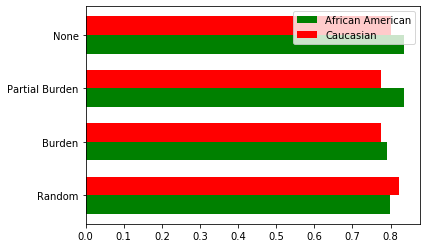

In [22]:
rf_aa_dp = rf_aa_m.datadf['pred'].round().mean() 
rf_c_dp  = rf_c_m.datadf['pred'].round().mean()

bf_aa_dp = bf_aa_m.datadf['pred'].round().mean()
bf_c_dp  = bf_c_m.datadf['pred'].round().mean()

aa_dp = aa_m.datadf['pred'].round().mean()
c_dp  = c_m.datadf['pred'].round().mean()

p_bf_aa_dp = p_bf_aa_m.datadf['pred'].round().mean()
p_bf_c_dp  = p_bf_c_m.datadf['pred'].round().mean()


print("random demo parity")
print(rf_c_dp)
print(rf_aa_dp)
print()

print("burden demo parity")
print(bf_c_dp)
print(bf_aa_dp)
print()

print("partial burden demo parity")
print(p_bf_c_dp)
print(p_bf_aa_dp)
print()

print("none demo parity")
print(c_dp)
print(aa_dp)
print()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
aa_dps = [rf_aa_dp,
         bf_aa_dp,
         p_bf_aa_dp,
         aa_dp]
c_dps  = [rf_c_dp,
         bf_c_dp,
         p_bf_c_dp,
         c_dp]
ind = np.arange(4)
width = .35
ax.barh(ind, aa_dps, width, color='g', label='African American')
ax.barh(ind+width, c_dps, width, color='r', label='Caucasian')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(('Random', 'Burden', 'Partial Burden', 'None'))
ax.legend()
plt.show()

### equ. odds and opp

Pr{^Y= 1|A= 0,Y= 1}= Pr{^Y= 1|A= 1,Y= 1} is opp

random eq opp
0.9708738
0.9433962

burden eq opp
0.8905473
0.8917836

partial burden eq opp
0.8905473
0.9498998

default eq opp
0.96517414
0.9498998



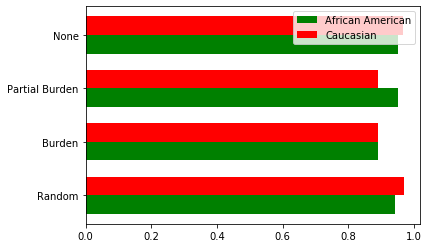

In [24]:
rf_aa_eqop = rf_aa_m.datadf.query("accepted == 1")['pred'].round().mean()
rf_c_eqop  = rf_c_m.datadf.query("accepted == 1")['pred'].round().mean()

bf_aa_eqop = bf_aa_m.datadf.query("accepted == 1")['pred'].round().mean()
bf_c_eqop  = bf_c_m.datadf.query("accepted == 1")['pred'].round().mean()

p_bf_aa_eqop = p_bf_aa_m.datadf.query("accepted == 1")['pred'].round().mean()
p_bf_c_eqop  = p_bf_c_m.datadf.query("accepted == 1")['pred'].round().mean()

aa_eqop = aa_m.datadf.query("accepted == 1")['pred'].round().mean()
c_eqop  = c_m.datadf.query("accepted == 1")['pred'].round().mean()

print("random eq opp")
print(rf_c_eqop)
print(rf_aa_eqop)
print()

print("burden eq opp")
print(bf_c_eqop)
print(bf_aa_eqop)
print()

print("partial burden eq opp")
print(p_bf_c_eqop)
print(p_bf_aa_eqop)
print()

print("default eq opp")
print(c_eqop)
print(aa_eqop)
print()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
aa_dps = [rf_aa_eqop,
         bf_aa_eqop,
         p_bf_aa_eqop,
         aa_eqop]
c_dps  = [rf_c_eqop,
         bf_c_eqop,
         p_bf_c_eqop,
         c_eqop]
ind = np.arange(4)
width = .35
ax.barh(ind, aa_dps, width, color='g', label='African American')
ax.barh(ind+width, c_dps, width, color='r', label='Caucasian')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(('Random', 'Burden', 'Partial Burden', 'None'))
ax.legend()
plt.show()

random eq odds
given y = 0
0.52884614
0.4741784
delta:  0.05466774
given y = 1
0.9708738
0.9433962
delta:  0.027477562

burden eq odds
given y = 0
0.559633
0.52879584
delta:  0.030837178
given y = 1
0.8905473
0.8917836
delta:  -0.0012363195

partial burden eq odds
given y = 0
0.559633
0.539267
delta:  0.020366013
given y = 1
0.8905473
0.9498998
delta:  -0.059352517

default eq odds
given y = 0
0.49541286
0.539267
delta:  -0.043854147
given y = 1
0.96517414
0.9498998
delta:  0.015274346



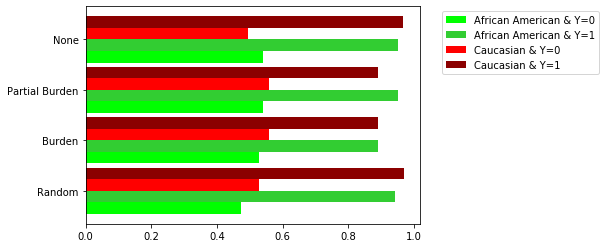

In [25]:
rf_aa_eq1 = rf_aa_m.datadf.query("accepted == 1")['pred'].round().mean()
rf_c_eq1  = rf_c_m.datadf.query("accepted == 1")['pred'].round().mean()
rf_aa_eq0 = rf_aa_m.datadf.query("accepted == 0")['pred'].round().mean()
rf_c_eq0  = rf_c_m.datadf.query("accepted == 0")['pred'].round().mean()


bf_aa_eq1 = bf_aa_m.datadf.query("accepted == 1")['pred'].round().mean()
bf_c_eq1  = bf_c_m.datadf.query("accepted == 1")['pred'].round().mean()
bf_aa_eq0 = bf_aa_m.datadf.query("accepted == 0")['pred'].round().mean()
bf_c_eq0  = bf_c_m.datadf.query("accepted == 0")['pred'].round().mean()

p_bf_aa_eq1 = p_bf_aa_m.datadf.query("accepted == 1")['pred'].round().mean()
p_bf_c_eq1  = p_bf_c_m.datadf.query("accepted == 1")['pred'].round().mean()
p_bf_aa_eq0 = p_bf_aa_m.datadf.query("accepted == 0")['pred'].round().mean()
p_bf_c_eq0  = p_bf_c_m.datadf.query("accepted == 0")['pred'].round().mean()


aa_eq1 = aa_m.datadf.query("accepted == 1")['pred'].round().mean()
c_eq1  = c_m.datadf.query("accepted == 1")['pred'].round().mean()
aa_eq0 = aa_m.datadf.query("accepted == 0")['pred'].round().mean()
c_eq0  = c_m.datadf.query("accepted == 0")['pred'].round().mean()


print("random eq odds")
print("given y = 0")
print(rf_c_eq0)
print(rf_aa_eq0)
print("delta: ", rf_c_eq0-rf_aa_eq0)
print("given y = 1")
print(rf_c_eq1)
print(rf_aa_eq1)
print("delta: ", rf_c_eq1-rf_aa_eq1)
print()

print("burden eq odds")
print("given y = 0")
print(bf_c_eq0)
print(bf_aa_eq0)
print("delta: ", bf_c_eq0-bf_aa_eq0)
print("given y = 1")
print(bf_c_eq1)
print(bf_aa_eq1)
print("delta: ", bf_c_eq1-bf_aa_eq1)
print()

print("partial burden eq odds")
print("given y = 0")
print(p_bf_c_eq0)
print(p_bf_aa_eq0)
print("delta: ", p_bf_c_eq0-p_bf_aa_eq0)
print("given y = 1")
print(p_bf_c_eq1)
print(p_bf_aa_eq1)
print("delta: ", p_bf_c_eq1-p_bf_aa_eq1)
print()

print("default eq odds")
print("given y = 0")
print(c_eq0)
print(aa_eq0)
print("delta: ", c_eq0-aa_eq0)
print("given y = 1")
print(c_eq1)
print(aa_eq1)
print("delta: ", c_eq1-aa_eq1)
print()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
aa_dps_0 = [rf_aa_eq0,
         bf_aa_eq0,
         p_bf_aa_eq0,
         aa_eq0]
c_dps_0  = [rf_c_eq0,
         bf_c_eq0,
         p_bf_c_eq0,
         c_eq0]
aa_dps_1 = [rf_aa_eq1,
         bf_aa_eq1,
         p_bf_aa_eq1,
         aa_eq1]
c_dps_1  = [rf_c_eq1,
         bf_c_eq1,
         p_bf_c_eq1,
         c_eq1]

ind = np.arange(4)
width = .23
ax.barh(ind, aa_dps_0, width, color='lime', label='African American & Y=0')
ax.barh(ind+width, aa_dps_1, width, color='limegreen', label='African American & Y=1')
ax.barh(ind+(width*2), c_dps_0, width, color='red', label='Caucasian & Y=0')
ax.barh(ind+(width*3), c_dps_1, width, color='darkred', label='Caucasian & Y=1')
ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_yticks((ind + (width*3/2)))
ax.set_yticklabels(('Random', 'Burden', 'Partial Burden', 'None'))

plt.show()

In [30]:
rf_aa_eq1 = rf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
rf_c_eq1  = rf_c_m.datadf.query("Low == 1")['pred'].round().mean()
rf_aa_eq0 = rf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
rf_c_eq0  = rf_c_m.datadf.query("Low == 0")['pred'].round().mean()


bf_aa_eq1 = bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
bf_c_eq1  = bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
bf_aa_eq0 = bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
bf_c_eq0  = bf_c_m.datadf.query("Low == 0")['pred'].round().mean()

p_bf_aa_eq1 = p_bf_aa_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_c_eq1  = p_bf_c_m.datadf.query("Low == 1")['pred'].round().mean()
p_bf_aa_eq0 = p_bf_aa_m.datadf.query("Low == 0")['pred'].round().mean()
p_bf_c_eq0  = p_bf_c_m.datadf.query("Low == 0")['pred'].round().mean()


aa_eq1 = aa_m.datadf.query("Low == 1")['pred'].round().mean()
c_eq1  = c_m.datadf.query("Low == 1")['pred'].round().mean()
aa_eq0 = aa_m.datadf.query("Low == 0")['pred'].round().mean()
c_eq0  = c_m.datadf.query("Low == 0")['pred'].round().mean()


print("random eq odds")
print("given y = 0")
print(rf_c_eq0)
print(rf_aa_eq0)
print("delta: ", rf_c_eq0-rf_aa_eq0)
print("given y = 1")
print(rf_c_eq1)
print(rf_aa_eq1)
print("delta: ", rf_c_eq1-rf_aa_eq1)
print()

print("burden eq odds")
print("given y = 0")
print(bf_c_eq0)
print(bf_aa_eq0)
print("delta: ", bf_c_eq0-bf_aa_eq0)
print("given y = 1")
print(bf_c_eq1)
print(bf_aa_eq1)
print("delta: ", bf_c_eq1-bf_aa_eq1)
print()

print("partial burden eq odds")
print("given y = 0")
print(p_bf_c_eq0)
print(p_bf_aa_eq0)
print("delta: ", p_bf_c_eq0-p_bf_aa_eq0)
print("given y = 1")
print(p_bf_c_eq1)
print(p_bf_aa_eq1)
print("delta: ", p_bf_c_eq1-p_bf_aa_eq1)
print()

print("default eq odds")
print("given y = 0")
print(c_eq0)
print(aa_eq0)
print("delta: ", c_eq0-aa_eq0)
print("given y = 1")
print(c_eq1)
print(aa_eq1)
print("delta: ", c_eq1-aa_eq1)
print()

random eq odds
given y = 0
0.23237886
0.33375314
delta:  -0.10137428
given y = 1
0.8058577
0.83553874
delta:  -0.029681027

burden eq odds
given y = 0
0.23132184
0.5215965
delta:  -0.29027465
given y = 1
0.62473345
0.8751857
delta:  -0.25045228

partial burden eq odds
given y = 0
0.43103448
0.2438491
delta:  0.18718538
given y = 1
0.8983653
0.743685
delta:  0.15468031

default eq odds
given y = 0
0.43103448
0.2438491
delta:  0.18718538
given y = 1
0.8983653
0.743685
delta:  0.15468031

